# Imports

In [1]:
%load_ext autoreload
%autoreload 2
import os
import pickle as pkl
import sys
import time

import arviz as az
import jax
from jax import numpy as jnp
from jax.random import PRNGKey
import numpy as np
import pandas as pd
import pymc as pm
from optax import adam
import tensorflow_probability.substrates.jax.distributions as tfd
from tensorflow_probability.substrates.jax.math import fill_triangular
from tqdm import tqdm

from matplotlib import pyplot as plt

sys.path.append(os.path.abspath(".."))
from scripts.notebook_utils import (
    plot_elbo, 
    plot_true_predicted_comparison, 
    plot_regression_results, 
    plot_synthetic_data,
    plot_data,
    plot_gpd_qq_plot,
    GPD_LOC_COLOR,
    GPD_SCALE_COLOR,
    GPD_SHAPE_COLOR,
    ELBO_COLOR,
    EXCESS_COLOR,
    SCATTERPLOT_COLOR,
    QUANTILE_COLOR,
    QUANTILE_HDI_COLOR,
    GPD_MEAN_COLOR,
    GPD_MEAN_HDI_COLOR,
    QQ_SCATTER_LINE,
    QQ_SCATTER_QUANTILES,
)
from scripts.vigamlss import (
    Normal, 
    DataPreparator, 
    DegenerateNormal, 
    FullCovarianceNormal, 
    HalfCauchy, 
    TransformationFunctions,
    GPD,
    ALD,
    CenteredGPD,
)

os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

2025-02-17 20:52:02.172996: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739821922.185200  598060 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739821922.189211  598060 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Save Dirs

In [2]:
plot_dir_case_study_gpd = sys.path[-1] + "/plots/case_study/gpd"
plot_dir_case_study_ald = sys.path[-1] + "/plots/case_study/ald"
plot_dir_sim = sys.path[-1] + "/plots/sim"

# VIGAMLSS Simulation Study

## Synthetic Data

### Preperations

#### Synthetic Data Creation

In [3]:
def vigamlss_gpd_create_syn_data(n_samples, seed, enable_plot=True):
    # ------------------------------------------------
    # 1) Generate covariate X
    # ------------------------------------------------
    key = PRNGKey(42)
    n_samples = n_samples
    key_x, key_y = jax.random.split(seed)
    X_SYN = jax.random.uniform(key_x, shape=(n_samples,), minval=-3.0, maxval=3.0).sort()

    # ------------------------------------------------
    # 2) Define parametric functions for loc(x), scale(x), shape(x)
    # ------------------------------------------------
    def loc_fn(x):
        return 0.1 * x**3 + 0.1 * np.sin(x)
    def scale_fn(x):
        return 0.1 * x**2 + 0.5

    def shape_fn(x):
        return 0.1 * jnp.tanh(x) - 0.2

    true_loc_vals = loc_fn(X_SYN)
    true_scale_vals = scale_fn(X_SYN)
    true_shape_vals = shape_fn(X_SYN)
    # ------------------------------------------------
    # 3) Constructs a *batch* of GPDs, one per (x_i).
    #    TFP automatically enforces domain logic for each sample.
    # ------------------------------------------------
    gpd_dists = tfd.GeneralizedPareto(
        loc=true_loc_vals,  # shape=(n_samples,)
        scale=true_scale_vals,  # shape=(n_samples,)
        concentration=true_shape_vals,  # shape=(n_samples,)
    )
    # ------------------------------------------------
    # 4) Sample Y given X
    # ------------------------------------------------
    Y_SYN = gpd_dists.sample(seed=key_y)  # shape=(n_samples,)
    Y_SYN = jnp.array(Y_SYN)
    if enable_plot:
        plot_synthetic_data(
            X=X_SYN,
            Y=Y_SYN,
            scatterplot_color=EXCESS_COLOR,
            line_palette=[
                GPD_LOC_COLOR,
                GPD_SCALE_COLOR,
                GPD_SHAPE_COLOR,
            ],
            lines=[true_loc_vals, true_scale_vals, true_shape_vals],
            scatter_xlabel="X",
            scatter_ylabel="Y ~ GPD(loc(X), scale(X), shape(X))",
            scatter_title="Synthetic Data for Regression with GPD Responses",
            line_xlabel="X",
            line_ylabel="Parameter Values",
            line_title="Parameter Variation w. r. t. X",
            line_labels=["loc(X)", "scale(X)", "shape(X)"],
            file_name="sim_syn_data",
            save_dir=plot_dir_sim,
        )

    return X_SYN, Y_SYN, true_loc_vals, true_scale_vals, true_shape_vals

#### Data Preperation

In [4]:
def vigamlss_gpd_sim_study_prepare_data(X_SYN):
    DesignMatrix, K, knots = DataPreparator(
        "DesignMatrix",
        X_SYN,
        "pspline",
        intercept=False,
        standardize=False,
        degree=3,
        num_knots=10,
        use_quantile=False,
        return_knots=True,
    )()
    return DesignMatrix, K, knots

#### Model Definition

In [5]:
def vigamlss_gpd_sim_study_define_model(DesignMatrix, Y_SYN, K):
    β0_loc = Normal("beta0_loc", jnp.array([0.0]), jnp.array([10.0]), 1)
    λ_loc = HalfCauchy("lambda_loc", jnp.array([0.01]), 1)
    γ_loc = DegenerateNormal("gammas_loc", K, λ_loc)

    β0_scale = Normal("beta0_scale", jnp.array([0.0]), jnp.array([10.0]), 1)
    λ_scale = HalfCauchy("lambda_scale", jnp.array([0.01]), 1)
    γ_scale = DegenerateNormal("gammas_scale", K, λ_scale)

    β0_shape = Normal("beta0_shape", jnp.array([0.0]), jnp.array([10.0]), 1)
    λ_shape = HalfCauchy("lambda_shape", jnp.array([0.01]), 1)
    γ_shape = DegenerateNormal("gammas_shape", K, λ_shape)

    Y = GPD(
        "y_GPD",
        β0_loc + DesignMatrix @ γ_loc,
        β0_scale + DesignMatrix @ γ_scale,
        β0_shape + DesignMatrix @ γ_shape,
        responses=Y_SYN,
    )
    return Y.model

#### Optimization Run

In [6]:
def vigamlss_gpd_sim_study_opt_run(model, seed, print_time=True):
    start_time = time.time()
    results = model.run_svi_optimization(
        optimizer=adam,
        vi_dist=FullCovarianceNormal,
        vi_sample_size=64,
        epochs=50000,
        mb_size=None,
        lr=0.001,
        max_norm=1.0,
        clip_min_max_enabled=True,
        zero_nans_enabled=True,
        prng_key=seed,
        scheduler_type="constant",
        # warmup_fraction=0.01,
        # end_value=1e-4,
        # init_value=1e-5,
    )
    end_time = time.time()
    elapsed_seconds = end_time - start_time
    minutes, seconds = divmod(elapsed_seconds, 60)
    if print_time:
        print(f"Elapsed time for optimization: {int(minutes)} min: {seconds:.2f} sec")
    return results

#### Results Aggregation

In [7]:
def vigamlss_gpd_sim_study_single_run_results(
    results, knots, X_SYN, Y_SYN, true_loc_vals, true_scale_vals, true_shape_vals
):
    β0_loc_opt = results["transformed_loc_vi_parameters"]["beta0_loc"]
    γ_loc_opt = results["transformed_loc_vi_parameters"]["gammas_loc"]
    β0_scale_opt = results["transformed_loc_vi_parameters"]["beta0_scale"]
    γ_scale_opt = results["transformed_loc_vi_parameters"]["gammas_scale"]
    β0_shape_opt = results["transformed_loc_vi_parameters"]["beta0_shape"]
    γ_shape_opt = results["transformed_loc_vi_parameters"]["gammas_shape"]

    linspace_X = jnp.linspace(X_SYN.min(), X_SYN.max(), 1000)
    pred_X = jnp.concatenate([linspace_X, X_SYN]).sort()

    PredDesignMatrix, _ = DataPreparator(
        "DesignMatrix",
        pred_X,
        "pspline",
        intercept=False,
        standardize=False,
        degree=3,
        num_knots=10,
        user_knots=knots,
    )()

    linear_predictor_loc = β0_loc_opt + PredDesignMatrix.matrix @ γ_loc_opt
    linear_predictor_scale = TransformationFunctions.softplus(
        β0_scale_opt + PredDesignMatrix.matrix @ γ_scale_opt
    )
    linear_predictor_shape = β0_shape_opt + PredDesignMatrix.matrix @ γ_shape_opt

    gpd_dists = tfd.GeneralizedPareto(
        linear_predictor_loc, linear_predictor_scale, linear_predictor_shape
    )
    with jax.default_device(jax.devices("cpu")[0]):
        samples = gpd_dists.sample((50000,), PRNGKey(0))
    samples = np.array(samples)

    pred_mean_line = gpd_dists.mean()
    pred_hdi_bounds = az.hdi(samples, hdi_prob=0.95)
    pred_hdi_lower = pred_hdi_bounds[:, 0]
    pred_hdi_upper = pred_hdi_bounds[:, 1]

    plot_elbo(
        num_iterations=results["svi_metadata"]["num_iterations"],
        title=f"SVI ELBO Convergence: Synthetic Data with GPD Responses: N={len(Y_SYN)}",
        elbo_values=results["losses"],
        elbo_color=ELBO_COLOR,
        initial_percentage=0.02,
        final_percentage=0.8,
        save_dir=plot_dir_sim,
        file_name=f"sigle_run_syn_data_elbo_N{len(Y_SYN)}",
    )
    plot_regression_results(
        scatter_x=X_SYN,
        scatter_y=Y_SYN,
        line_xs=[pred_X],
        regression_lines=[pred_mean_line],
        hdi_lower_bounds=[pred_hdi_lower],
        hdi_upper_bounds=[pred_hdi_upper],
        hdi_alphas=[0.2],
        regression_line_colors=[GPD_MEAN_COLOR],
        hdi_colors=[GPD_MEAN_HDI_COLOR],
        hdi_labels=["95% HDI"],
        scatter_color=EXCESS_COLOR,
        scatter_label="Data Points",
        regression_line_labels=["GPD Mean Regression Line"],
        x_label="X",
        y_label="Y ~ GPD(loc(X), scale(X), shape(X))",
        title=f"Bayesian GAMLSS P-Spline Regression for Synthetic Data with GPD Responses with 95% HDI: N={len(Y_SYN)}",
        fig_size=(12, 7),
        file_name=f"sigle_run_syn_data_regression_results_N{len(Y_SYN)}",
        save_dir=plot_dir_sim,
    )
    plot_true_predicted_comparison(
        X_SYN=X_SYN,
        X_PRED = pred_X,
        true_parameter_values=[true_loc_vals, true_scale_vals, true_shape_vals],
        predicted_parameter_values=[
            linear_predictor_loc,
            linear_predictor_scale,
            linear_predictor_shape,
        ],
        true_palette=[GPD_LOC_COLOR, GPD_SCALE_COLOR, GPD_SHAPE_COLOR],
        pred_palette=[GPD_LOC_COLOR, GPD_SCALE_COLOR, GPD_SHAPE_COLOR],
        line_labels=["Location", "Scale", "Shape"],
        title=f"Comparison of True vs. Predicted GPD Parameters: N={len(Y_SYN)}",
        xlabel="X",
        ylabel="Parameter Value",
        save_dir=plot_dir_sim,
        file_name=f"sigle_run_syn_data_true_pred_comp_N{len(Y_SYN)}",
        fig_size=(7,7)
    )

### Conduct Simulation Study

#### Single Run 50000

##### N=50

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/sim_syn_data.svg


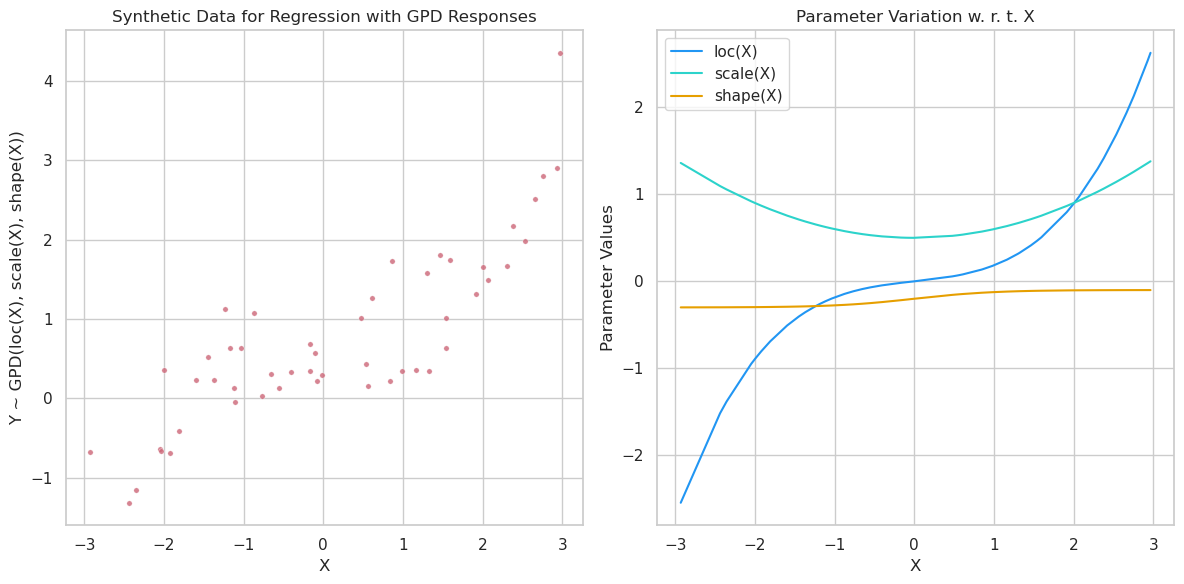

Elapsed time for optimization: 0 min: 25.74 sec


/tmp/ipykernel_598060/589642379.py:39: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pred_hdi_bounds = az.hdi(samples, hdi_prob=0.95)


Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/sigle_run_syn_data_elbo_N50.svg


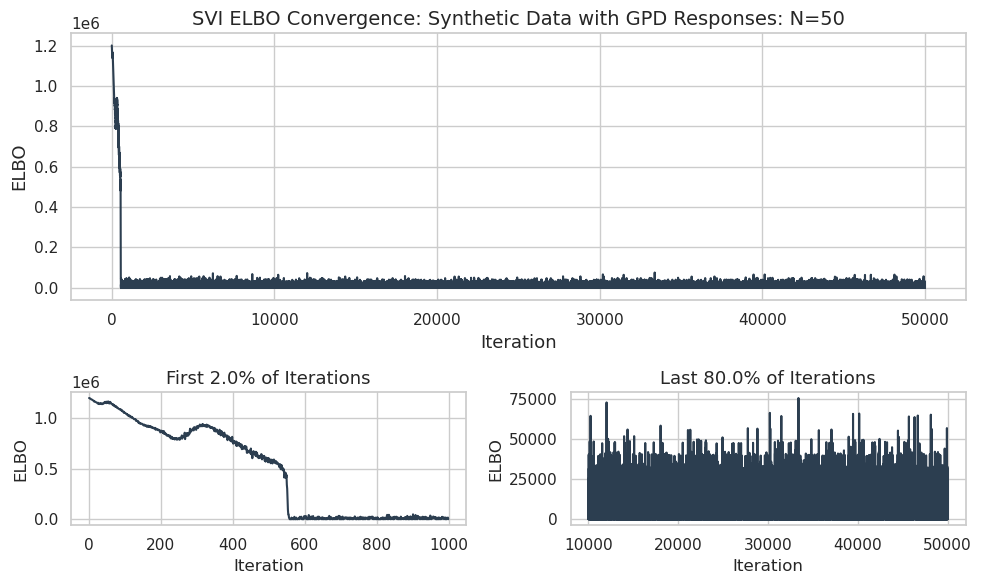

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/sigle_run_syn_data_regression_results_N50.svg


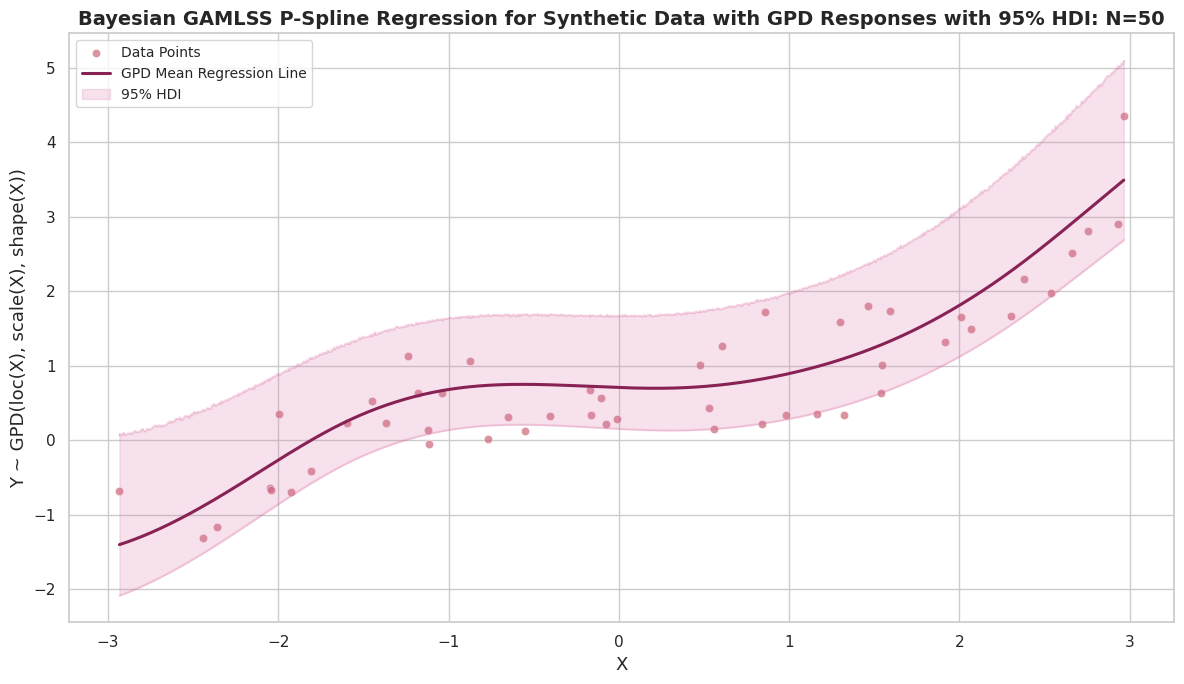

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/sigle_run_syn_data_true_pred_comp_N50.svg


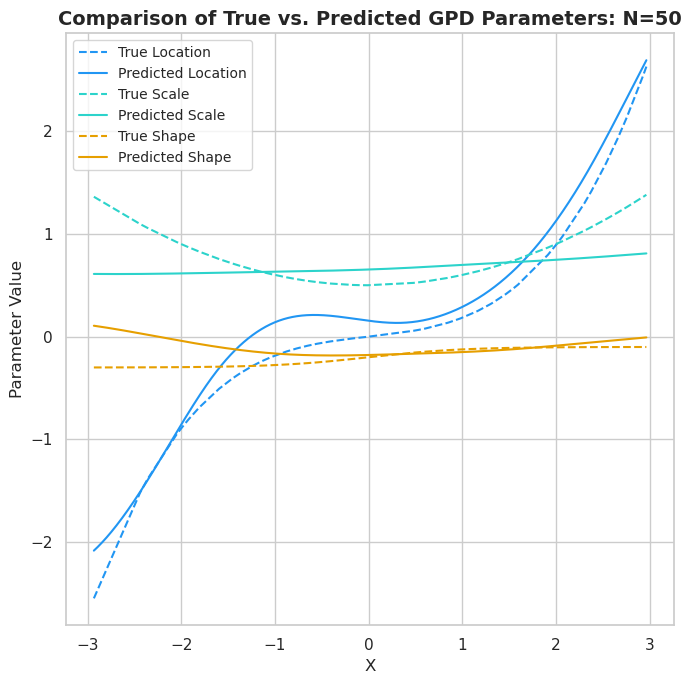

In [8]:
seed = PRNGKey(1)
seed_1, seed_2 = jax.random.split(seed)
X_SYN, Y_SYN, loc_vals, scale_vals, shape_vals = vigamlss_gpd_create_syn_data(50, seed_1)
DesignMatrix, K, knots = vigamlss_gpd_sim_study_prepare_data(X_SYN)
model = vigamlss_gpd_sim_study_define_model(DesignMatrix, Y_SYN, K)
results = vigamlss_gpd_sim_study_opt_run(model, seed_2)
vigamlss_gpd_sim_study_single_run_results(results, knots, X_SYN, Y_SYN, loc_vals, scale_vals, shape_vals)

##### N=100

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/sim_syn_data.svg


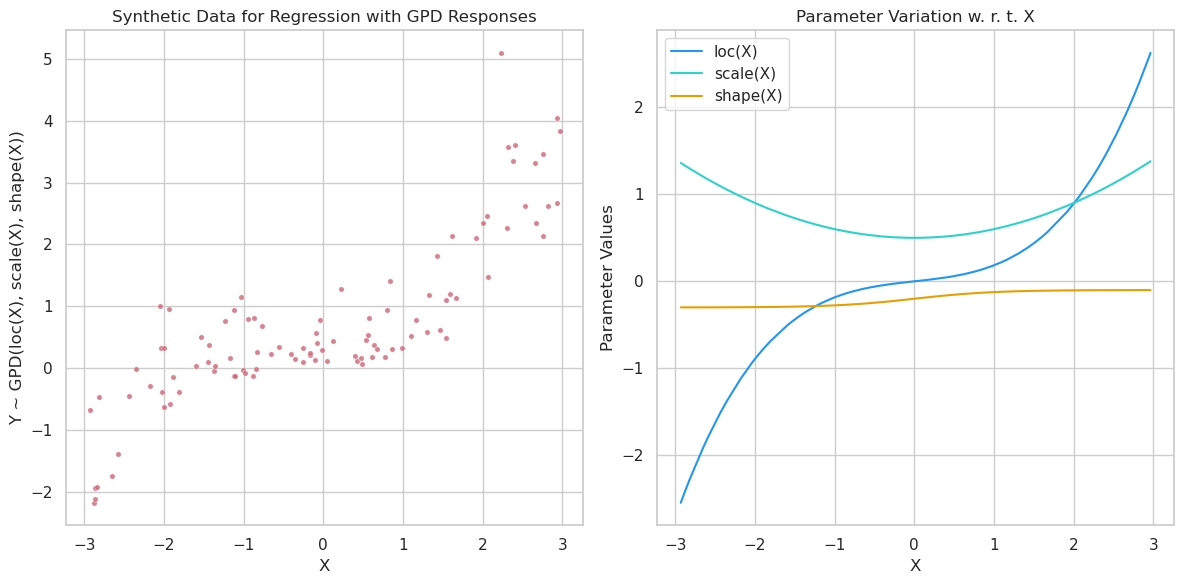

Elapsed time for optimization: 0 min: 24.87 sec


/tmp/ipykernel_598060/589642379.py:39: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pred_hdi_bounds = az.hdi(samples, hdi_prob=0.95)


Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/sigle_run_syn_data_elbo_N100.svg


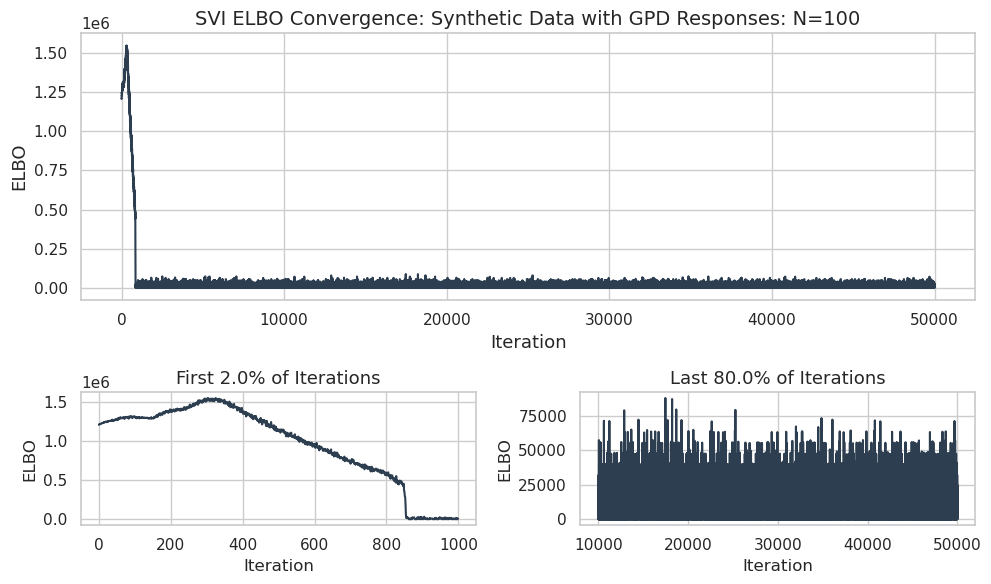

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/sigle_run_syn_data_regression_results_N100.svg


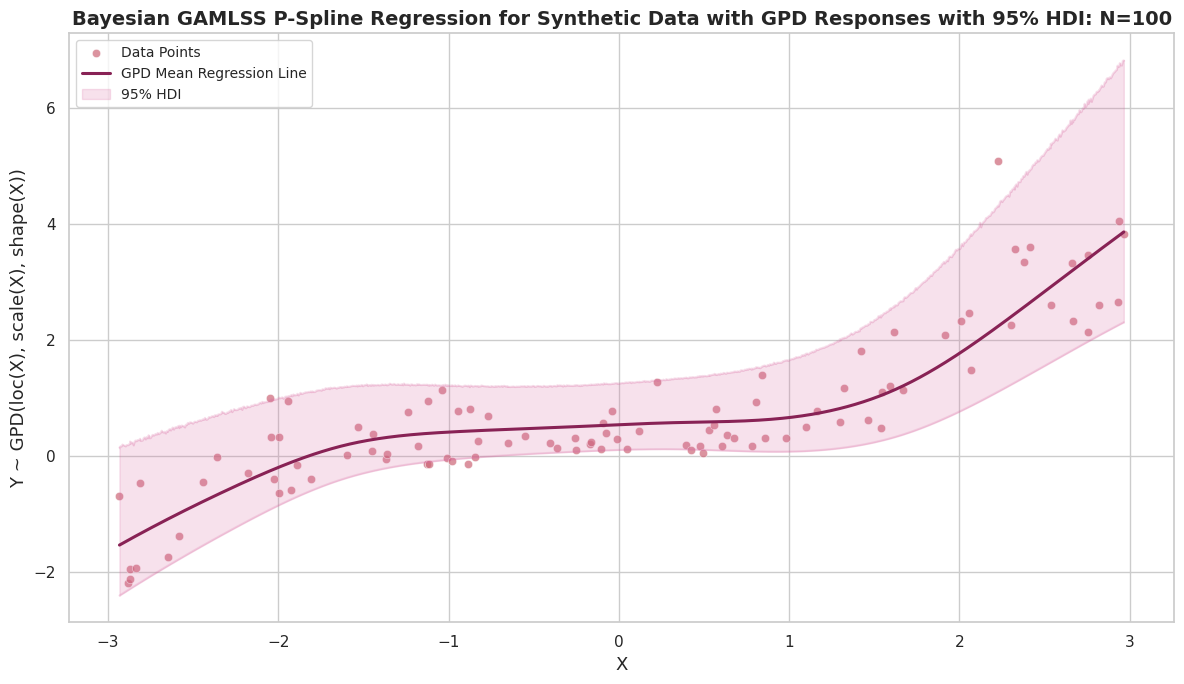

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/sigle_run_syn_data_true_pred_comp_N100.svg


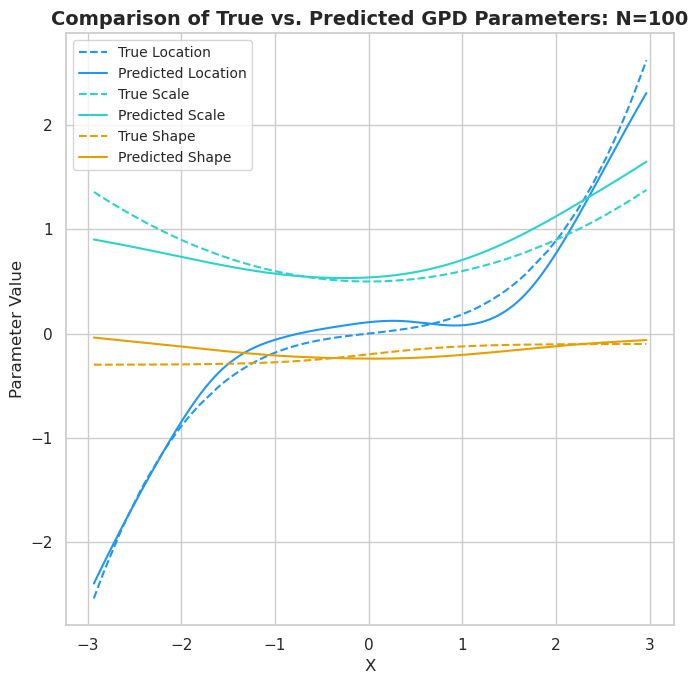

In [9]:
seed = PRNGKey(1)
seed_1, seed_2 = jax.random.split(seed)
X_SYN, Y_SYN, loc_vals, scale_vals, shape_vals = vigamlss_gpd_create_syn_data(100, seed_1)
DesignMatrix, K, knots = vigamlss_gpd_sim_study_prepare_data(X_SYN)
model = vigamlss_gpd_sim_study_define_model(DesignMatrix, Y_SYN, K)
results = vigamlss_gpd_sim_study_opt_run(model, seed_2)
vigamlss_gpd_sim_study_single_run_results(results, knots, X_SYN, Y_SYN, loc_vals, scale_vals, shape_vals)

##### N=500

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/sim_syn_data.svg


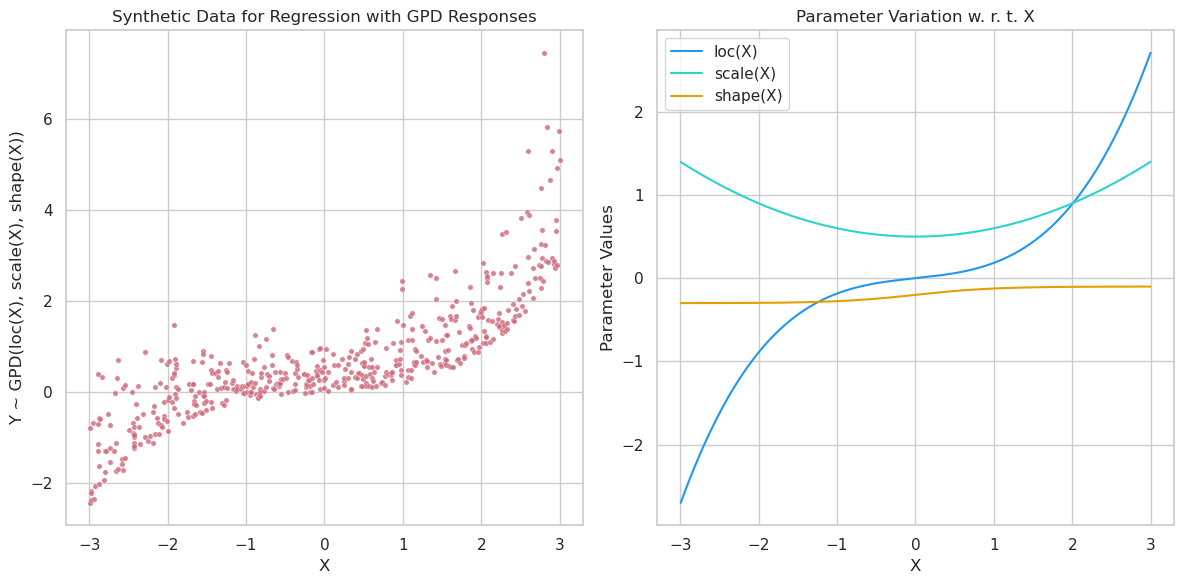

Elapsed time for optimization: 0 min: 27.92 sec


/tmp/ipykernel_598060/589642379.py:39: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pred_hdi_bounds = az.hdi(samples, hdi_prob=0.95)


Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/sigle_run_syn_data_elbo_N500.svg


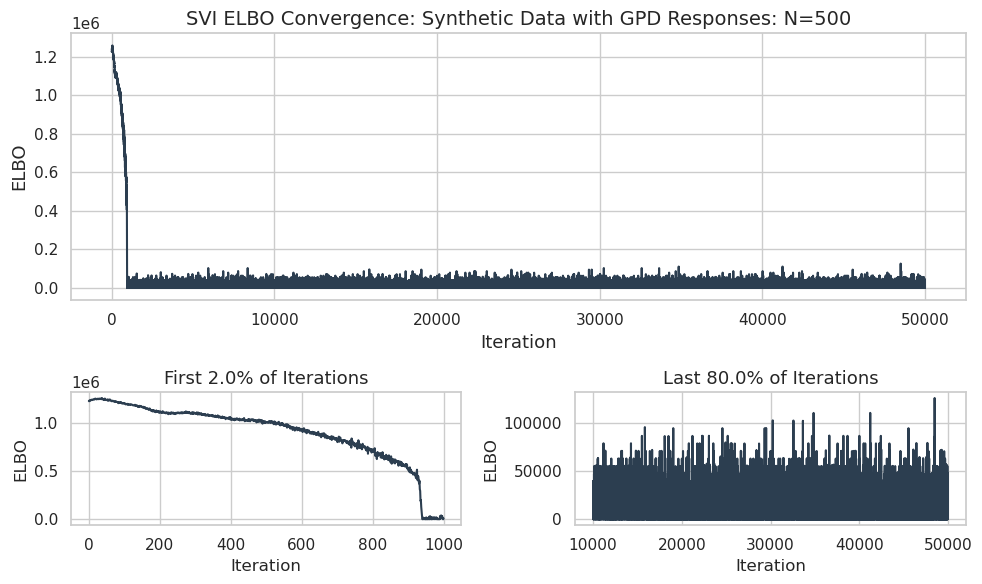

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/sigle_run_syn_data_regression_results_N500.svg


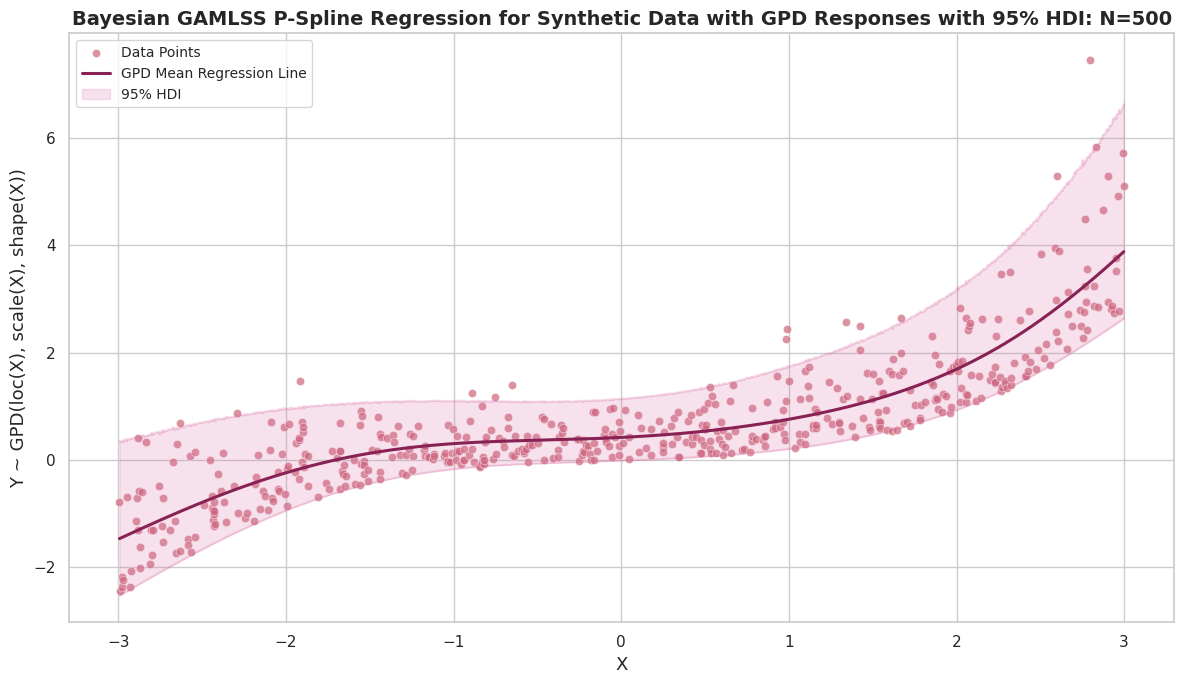

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/sigle_run_syn_data_true_pred_comp_N500.svg


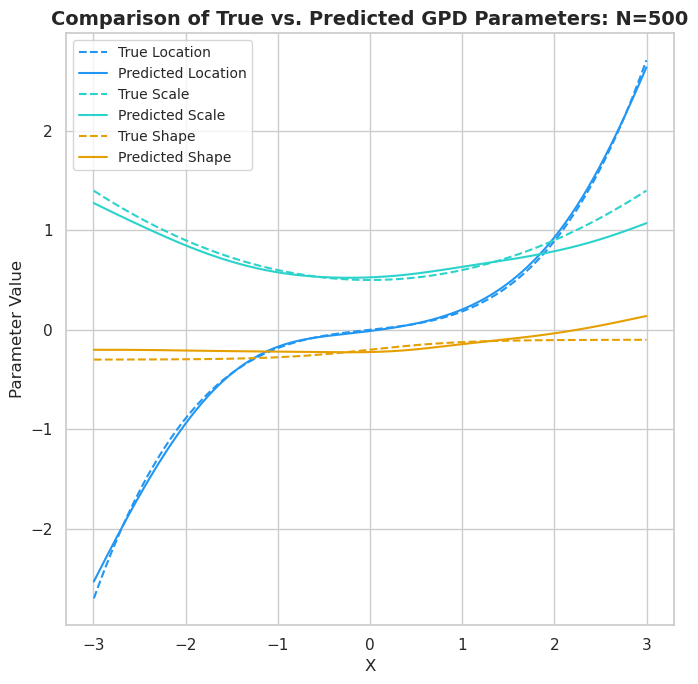

In [10]:
seed = PRNGKey(1)
seed_1, seed_2 = jax.random.split(seed)
X_SYN, Y_SYN, loc_vals, scale_vals, shape_vals = vigamlss_gpd_create_syn_data(500, seed_1)
DesignMatrix, K, knots = vigamlss_gpd_sim_study_prepare_data(X_SYN)
model = vigamlss_gpd_sim_study_define_model(DesignMatrix, Y_SYN, K)
results = vigamlss_gpd_sim_study_opt_run(model, seed_2)
vigamlss_gpd_sim_study_single_run_results(results, knots, X_SYN, Y_SYN, loc_vals, scale_vals, shape_vals)

##### N=1000m

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/sim_syn_data.svg


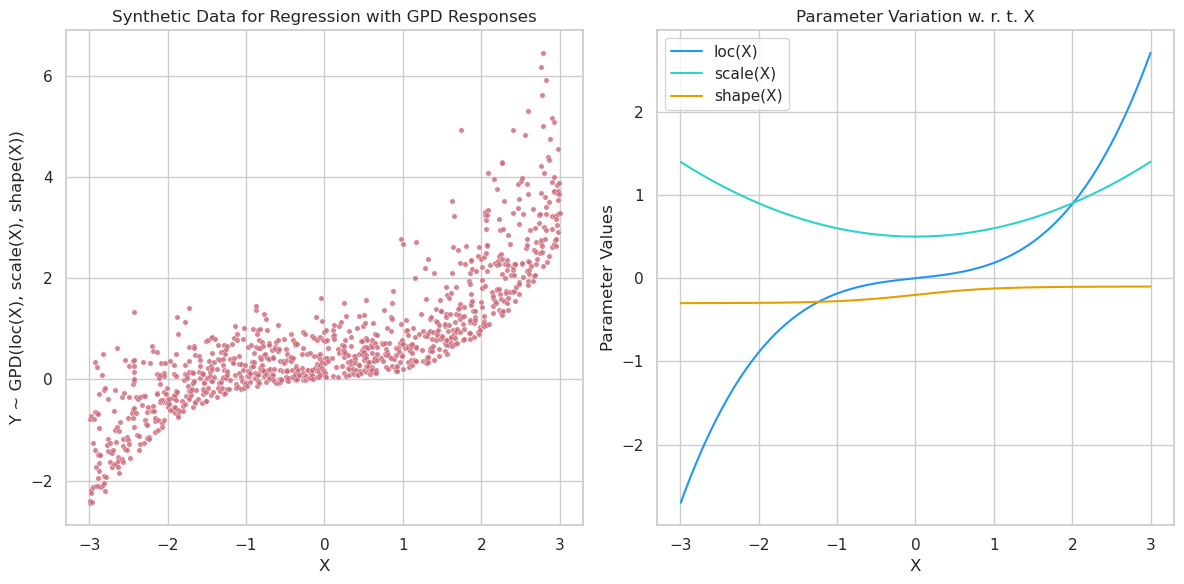

Elapsed time for optimization: 0 min: 27.40 sec


/tmp/ipykernel_598060/589642379.py:39: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pred_hdi_bounds = az.hdi(samples, hdi_prob=0.95)


Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/sigle_run_syn_data_elbo_N1000.svg


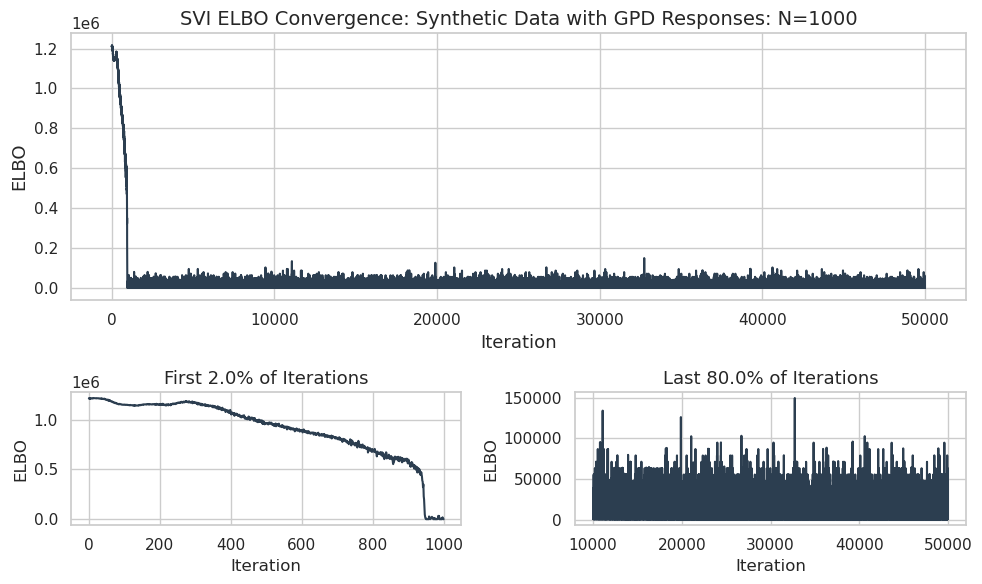

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/sigle_run_syn_data_regression_results_N1000.svg


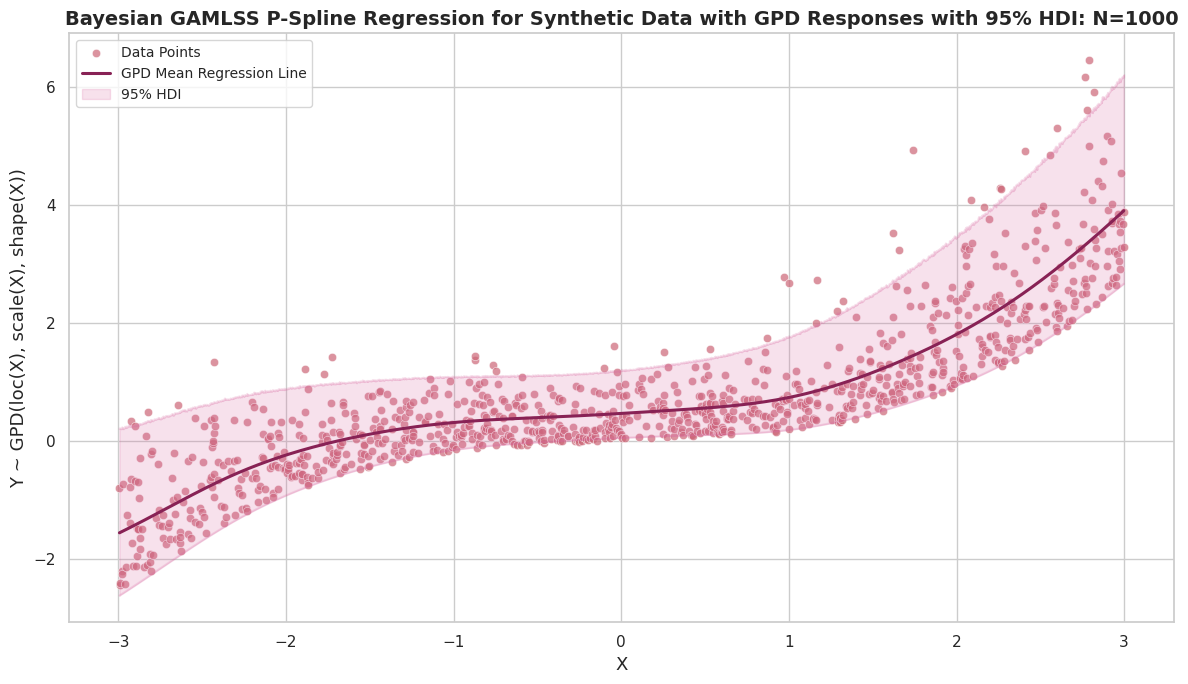

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/sigle_run_syn_data_true_pred_comp_N1000.svg


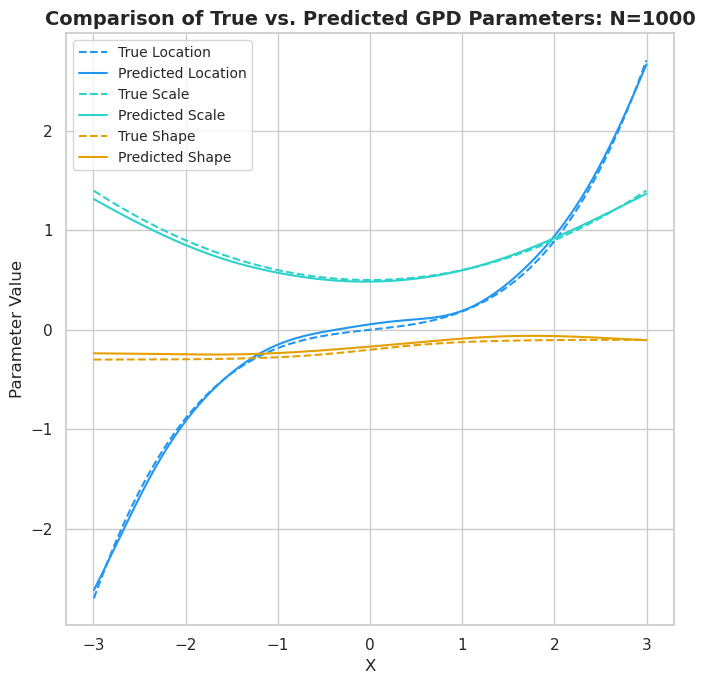

In [11]:
seed = PRNGKey(1)
seed_1, seed_2 = jax.random.split(seed)
X_SYN, Y_SYN, loc_vals, scale_vals, shape_vals = vigamlss_gpd_create_syn_data(1000, seed_1)
DesignMatrix, K, knots = vigamlss_gpd_sim_study_prepare_data(X_SYN)
model = vigamlss_gpd_sim_study_define_model(DesignMatrix, Y_SYN, K)
results = vigamlss_gpd_sim_study_opt_run(model, seed_2)
vigamlss_gpd_sim_study_single_run_results(results, knots, X_SYN, Y_SYN, loc_vals, scale_vals, shape_vals)

#### Simulation Study

In [12]:
num_replications = 100
num_samples = 100
for i in tqdm(range(num_replications)):
    break  # because we already gathered everything
    seed = PRNGKey(i)
    seed_1, seed_2 = jax.random.split(seed)
    X_SYN_SIM, Y_SYN_SIM, loc_vals_SIM, scale_vals_SIM, shape_vals_SIM = vigamlss_gpd_create_syn_data(num_samples, seed_1, enable_plot=False)
    DesignMatrix, K = vigamlss_gpd_syn_data_prepare_data(X_SYN_SIM)
    model = vigamlss_gpd_syn_data_define_model(DesignMatrix, Y_SYN_SIM, K)
    results = vigamlss_gpd_syn_data_opt_run(model, seed_2, print_time=False)
    with open(pickle_dir_gpd_sim + f"/results_gpd_seed_{i}.pickle", 'wb') as handle:
        pkl.dump(results, handle)

  0%|          | 0/100 [00:00<?, ?it/s]


### NUTS MCMC

# VIGAMLSS for DBBMI

## Build Bayesian Quantile Regression Model

In [13]:
def vigamlss_dbbmi_prepare_qr_data():
    dbbmi_df = pd.read_csv("../data/dbbmi_data.csv")
    X = dbbmi_df["age"].values
    Y = dbbmi_df["bmi"].values
    X = jnp.array(X)
    Y = jnp.array(Y)
    sort_indices = jnp.argsort(X)
    X = X[sort_indices]
    Y = Y[sort_indices]
    DesignMatrix, K, knots = DataPreparator(
        "dbbmi DesignMatrix",
        X,
        "pspline",
        intercept=False,
        standardize=False,
        degree=3,
        num_knots=10,
        use_quantile=True,
        return_knots=True,
    )()
    return DesignMatrix, X, Y, K, knots


def vigamlss_dbbmi_qr_define_model(DesignMatrix, Y, K, tau=0.97):
    β0_loc = Normal("beta0_loc", jnp.array([0.0]), jnp.array([10.0]), 1)
    λ_loc = HalfCauchy("lambda_loc", jnp.array([0.1]), 1)
    γ_loc = DegenerateNormal("gammas_loc", K, λ_loc)

    β0_scale = Normal("beta0_scale", jnp.array([0.0]), jnp.array([10.0]), 1)
    λ_scale = HalfCauchy("lambda_scale", jnp.array([0.1]), 1)
    γ_scale = DegenerateNormal("gammas_scale", K, λ_scale)

    Y = ALD(
        rv_name="y_GPD",
        loc=β0_loc + DesignMatrix @ γ_loc,
        scale=β0_scale + DesignMatrix @ γ_scale,
        tau=tau,
        responses=Y,
    )
    return Y.model, tau


def vigamlss_dbbmi_qr_opt_run(model, epochs):
    results = model.run_svi_optimization(
        optimizer=adam,
        vi_dist=FullCovarianceNormal,
        vi_sample_size=64,
        epochs=epochs,
        mb_size=None,
        lr=0.01,
        max_norm=1.0,
        clip_min_max_enabled=False,
        zero_nans_enabled=False,
        prng_key=PRNGKey(0),
        scheduler_type="warmup_cosine_decay",
        warmup_fraction=0.01,
        end_value=1e-4,
        init_value=1e-5,
    )
    return results


def vigamlss_dbbmi_qr_results(results_QR, model_QR, knots_QR, X, Y, tau):
    β0_loc_opt = results_QR["transformed_loc_vi_parameters"]["beta0_loc"]
    γ_loc_opt = results_QR["transformed_loc_vi_parameters"]["gammas_loc"]
    # -----------------------------------------------------------------
    # The following in order to sample β0_loc & γ_loc from the joint posterior
    # to create a HDI
    split_indices = model_QR.split_indices
    transformations = model_QR.transformations
    rv_names = model_QR.rv_names
    variational_loc = results_QR["loc_vi_parameters_vec"]
    chol_vec = results_QR["chol_vi_vec"]
    variational_lower_triangle = fill_triangular(chol_vec)
    mvn_tril = tfd.MultivariateNormalTriL(variational_loc, variational_lower_triangle)
    with jax.default_device(jax.devices("gpu")[0]):
        loc_vi_parameters_samples = mvn_tril.sample((10000,), PRNGKey(0))
    grouped_loc_vi_parameters_samples = tuple(
        jnp.split(loc_vi_parameters_samples, split_indices, axis=1)
    )
    num_loc_vi_groups = len(grouped_loc_vi_parameters_samples)
    transformed_loc_vi_parameters_samples = jax.tree.map(
        lambda trans, x: trans(x),
        transformations[:num_loc_vi_groups],
        grouped_loc_vi_parameters_samples,
    )
    dict_loc_vi_parameters_samples = dict(
        zip(rv_names[:num_loc_vi_groups], transformed_loc_vi_parameters_samples)
    )
    β0_loc_samples = dict_loc_vi_parameters_samples["beta0_loc"]
    γ_loc_samples = dict_loc_vi_parameters_samples["gammas_loc"]

    # For Threshold Prediction
    # 1) Collect indices
    num_lin_space = 10000
    lin_part = jnp.linspace(X.min(), X.max(), num_lin_space)
    pred_X_unsorted = jnp.concatenate([lin_part, X])
    indices = jnp.arange(num_lin_space + len(X))

    # 2) Sort combined array
    sorted_order = jnp.argsort(pred_X_unsorted)
    pred_X_sorted = pred_X_unsorted[sorted_order]

    # 3) Keep track of pred_X indices
    sorted_pred_X_idx = indices[sorted_order]

    # 4) Which sorted positions correspond to X vs. linspace?
    mask_X = sorted_pred_X_idx >= num_lin_space
    where_sample_X = jnp.where(mask_X)[0]

    pred_DesignMatrix, _ = DataPreparator(
        "pred DesignMatrix",
        pred_X_sorted,
        "pspline",
        intercept=False,
        standardize=False,
        degree=3,
        num_knots=10,
        user_knots=knots_QR,
    )()
    pred_thresholds = β0_loc_opt + pred_DesignMatrix.matrix @ γ_loc_opt
    with jax.default_device(jax.devices("gpu")[0]):
        pred_thresholds_samples = (
            β0_loc_samples + γ_loc_samples @ pred_DesignMatrix.matrix.T
        )
    pred_thresholds_samples = np.array(pred_thresholds_samples)

    estimated_pred_threshold_hdi_bounds = az.hdi(pred_thresholds_samples, hdi_prob=0.95)
    pred_threshold_hdi_lower = estimated_pred_threshold_hdi_bounds[:, 0]
    pred_threshold_hdi_upper = estimated_pred_threshold_hdi_bounds[:, 1]

    # -----------------------------------------------------------------
    # Compute peaks over threshold, i. e. the excesses
    diff = Y - pred_thresholds[where_sample_X]
    excess_mask = diff > 0
    Y_excess = diff[excess_mask]
    X_excess = X[excess_mask]

    plot_data(
        X=X,
        Y=Y,
        scatterplot_color=SCATTERPLOT_COLOR,
        scatter_xlabel="Age",
        scatter_ylabel="BMI",
        scatter_title="BMI vs. Age: Dutch Boys BMI Dataset",
        file_name="dbbmi_scatterplot",
        save_dir=plot_dir_case_study_ald,
    )
    plot_elbo(
        num_iterations=results_QR["svi_metadata"]["num_iterations"],
        title="SVI ELBO Convergence: Synthetic Data with ALD Responses: DBBMI Case Study",
        elbo_values=results_QR["losses"],
        elbo_color=ELBO_COLOR,
        initial_percentage=0.06,
        final_percentage=0.94,
        save_dir=plot_dir_case_study_ald,
        file_name="dbbmi_qr_elbo",
        apply_ma=(False, False, True),
        window=500,
        tick_label_plain=[False, False, True],
    )
    plot_regression_results(
        scatter_x=X,
        scatter_y=Y,
        line_xs=[pred_X_sorted],
        regression_lines=[pred_thresholds],
        hdi_lower_bounds=[pred_threshold_hdi_lower],
        hdi_upper_bounds=[pred_threshold_hdi_upper],
        hdi_alphas=[0.2],
        regression_line_colors=[QUANTILE_COLOR],
        hdi_colors=[QUANTILE_HDI_COLOR],
        hdi_labels=["95% HDI"],
        scatter_color=SCATTERPLOT_COLOR,
        scatter_label="Data Points",
        regression_line_labels=[f"{tau} Quantile Regression Line"],
        x_label="Age",
        y_label="BMI",
        title=f"Bayesian GAMLSS ALD P-Spline Quantile Regression of BMI on Age: {tau} Quantile with 95% HDI",
        fig_size=(12, 7),
        file_name="case_study_ald_regression_results",
        save_dir=plot_dir_case_study_ald,
        excess_mask=excess_mask,
        excess_color=EXCESS_COLOR,
    )
    return (
        Y_excess,
        X_excess,
        excess_mask,
        pred_X_sorted,
        mask_X,
        pred_thresholds,
        pred_threshold_hdi_lower,
        pred_threshold_hdi_upper,
    )


def vigamlss_dbbmi_prepare_gpd_data(X_excess):
    DesignMatrix, K, knots = DataPreparator(
        "dbbmi DesignMatrix",
        X_excess,
        "pspline",
        intercept=False,
        standardize=False,
        degree=3,
        num_knots=10,
        use_quantile=True,
        return_knots=True,
    )()
    return DesignMatrix, K, knots


def vigamlss_dbbmi_cgpd_define_model(DesignMatrix, Y, K):
    β0_scale = Normal("beta0_scale", jnp.array([0.0]), jnp.array([10.0]), 1)
    λ_scale = HalfCauchy("lambda_scale", jnp.array([0.1]), 1)
    γ_scale = DegenerateNormal("gammas_scale", K, λ_scale)

    β0_shape = Normal("beta0_shape", jnp.array([0.0]), jnp.array([10.0]), 1)
    λ_shape = HalfCauchy("lambda_shape", jnp.array([0.1]), 1)
    γ_shape = DegenerateNormal("gammas_shape", K, λ_shape)

    Y = CenteredGPD(
        "y_GPD",
        β0_scale + DesignMatrix @ γ_scale,
        β0_shape + DesignMatrix @ γ_shape,
        responses=Y,
    )
    return Y.model


def vigamlss_dbbmi_cgpd_opt_run(model, epochs):
    results = model.run_svi_optimization(
        optimizer=adam,
        vi_dist=FullCovarianceNormal,
        vi_sample_size=64,
        epochs=epochs,
        mb_size=None,
        lr=0.001,
        max_norm=1.0,
        clip_min_max_enabled=True,
        zero_nans_enabled=True,
        prng_key=PRNGKey(0),
        scheduler_type="constant",
    )
    return results


def vigamlss_dbbmi_cgpd_results(
    results_CGPD,
    X,
    Y,
    X_excess,
    Y_excess,
    knots,
    tau,
    excess_mask,
    pred_X,
    mask_X,
    pred_thresholds,
    pred_threshold_hdi_lower,
    pred_threshold_hdi_upper,
):
    β0_scale_opt = results_CGPD["transformed_loc_vi_parameters"]["beta0_scale"]
    γ_scale_opt = results_CGPD["transformed_loc_vi_parameters"]["gammas_scale"]
    β0_shape_opt = results_CGPD["transformed_loc_vi_parameters"]["beta0_shape"]
    γ_shape_opt = results_CGPD["transformed_loc_vi_parameters"]["gammas_shape"]

    X_excess_min, X_excess_max = X_excess.min(), X_excess.max()
    pred_X_clipped = jnp.clip(pred_X, a_min=X_excess_min, a_max=X_excess_max)

    excess_DesignMatrix, _ = DataPreparator(
        "xDesign",
        pred_X_clipped,
        "pspline",
        intercept=False,
        standardize=False,
        degree=3,
        num_knots=10,
        user_knots=knots,
    )()

    linear_predictor_scale = TransformationFunctions.softplus(
        β0_scale_opt + excess_DesignMatrix.matrix @ γ_scale_opt
    )
    linear_predictor_shape = β0_shape_opt + excess_DesignMatrix.matrix @ γ_shape_opt

    gpd_dists = tfd.GeneralizedPareto(
        pred_thresholds,
        linear_predictor_scale,
        linear_predictor_shape,
    )
    with jax.default_device(jax.devices("cpu")[0]):
        samples = gpd_dists.sample((100000,), PRNGKey(0))
    samples = np.array(samples)
    excess_gpd_mean_hdi_bounds = az.hdi(samples, hdi_prob=0.95)
    excess_gpd_mean_hdi_lower = excess_gpd_mean_hdi_bounds[:, 0]
    excess_gpd_mean_hdi_upper = excess_gpd_mean_hdi_bounds[:, 1]
    excess_gpd_mean_line = gpd_dists.mean()

    plot_elbo(
        num_iterations=results_CGPD["svi_metadata"]["num_iterations"],
        title="SVI ELBO Convergence: Synthetic Data with Zero-Centered GPD Responses: DBBMI Case Study",
        elbo_values=results_CGPD["losses"],
        elbo_color=ELBO_COLOR,
        initial_percentage=0.008,
        final_percentage=0.992,
        save_dir=plot_dir_case_study_gpd,
        file_name="cgpd_ddbi_elbo",
    )
    plot_gpd_qq_plot(
        linear_predictor_scale[mask_X][excess_mask],
        linear_predictor_shape[mask_X][excess_mask],
        Y_excess,
        QQ_SCATTER_LINE,
        QQ_SCATTER_QUANTILES,
        file_name="dbbmi_qq_plot",
        save_dir=plot_dir_case_study_gpd,
    )
    plot_regression_results(
        scatter_x=X,
        scatter_y=Y,
        line_xs=[pred_X,pred_X_clipped],
        regression_lines=[pred_thresholds, excess_gpd_mean_line],
        hdi_lower_bounds=[pred_threshold_hdi_lower, excess_gpd_mean_hdi_lower],
        hdi_upper_bounds=[pred_threshold_hdi_upper, excess_gpd_mean_hdi_upper],
        hdi_alphas=[0.2, 0.2],
        regression_line_colors=[QUANTILE_COLOR, GPD_MEAN_COLOR],
        hdi_colors=[QUANTILE_HDI_COLOR, GPD_MEAN_HDI_COLOR],
        hdi_labels=["95% ALD Quantile Regression Line HDI", "95% GPD Mean Regression Line HDI"],
        scatter_color=SCATTERPLOT_COLOR,
        scatter_label="Data Points",
        regression_line_labels=[
            f"{tau} Quantile Regression Line",
            "GPD Mean Regression Line",
        ],
        x_label="Age",
        y_label="BMI",
        title=f"Bayesian Peak-over-Threshold GAMLSS GPD P-Spline Regression of BMI on Age",
        fig_size=(12, 7),
        file_name="case_study_cgpd_regression_results",
        save_dir=plot_dir_case_study_ald,
        excess_mask=excess_mask,
        excess_color=EXCESS_COLOR,
        pred_param_x = pred_X_clipped,
        pred_param_lines = [linear_predictor_scale, linear_predictor_shape],
        pred_param_line_colors = [GPD_SCALE_COLOR, GPD_SHAPE_COLOR],
        pred_param_x_label = "Age",
        pred_param_y_label = "Parameter Values",
        pred_param_line_labels = ["Predicted Scale Line", "Predicted Shape Line"],
        pred_param_titles = ["Predicted GPD Scales w. r. t. Age", "Predicted GPD Shape w. r. t. Age"],
        pred_fig_size = (12,3),
        y_origin=16,
    )

/tmp/ipykernel_598060/1896759872.py:128: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  estimated_pred_threshold_hdi_bounds = az.hdi(pred_thresholds_samples, hdi_prob=0.95)


Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/case_study/ald/dbbmi_scatterplot.svg
Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/case_study/ald/dbbmi_scatterplot.svg


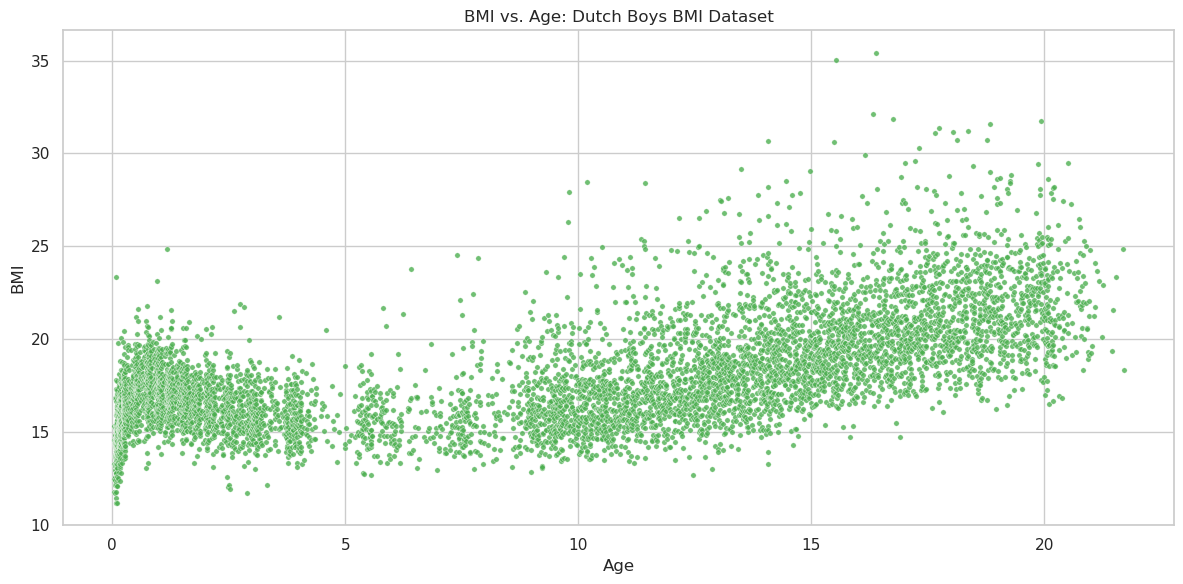

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/case_study/ald/dbbmi_qr_elbo.svg


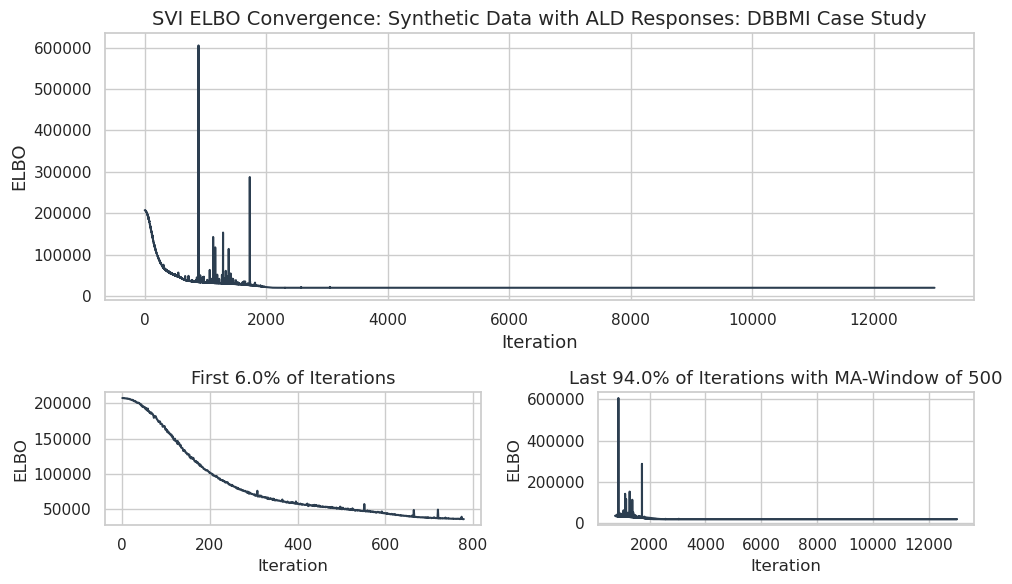

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/case_study/ald/case_study_ald_regression_results.svg


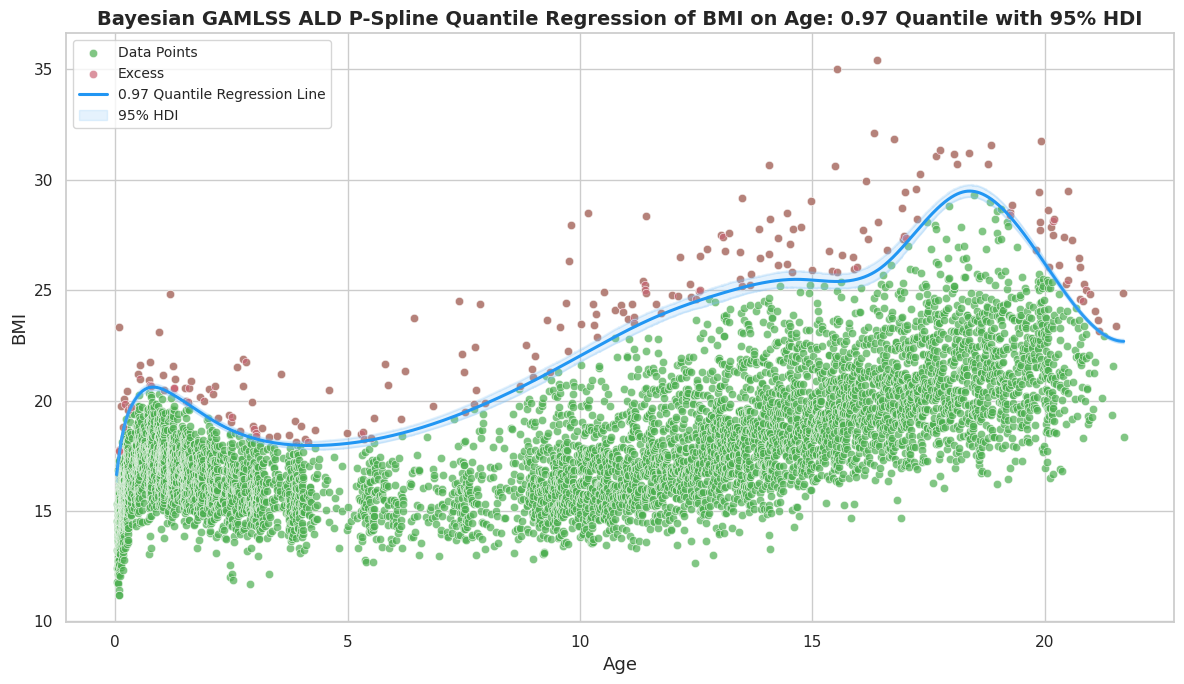

/tmp/ipykernel_598060/1896759872.py:294: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  excess_gpd_mean_hdi_bounds = az.hdi(samples, hdi_prob=0.95)


Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/case_study/gpd/cgpd_ddbi_elbo.svg


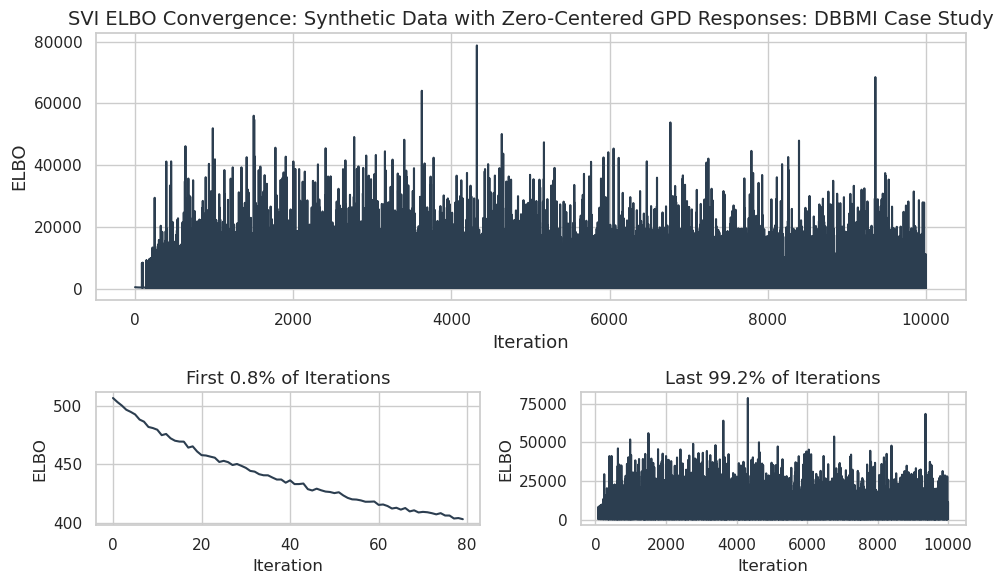

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/case_study/gpd/dbbmi_qq_plot.svg


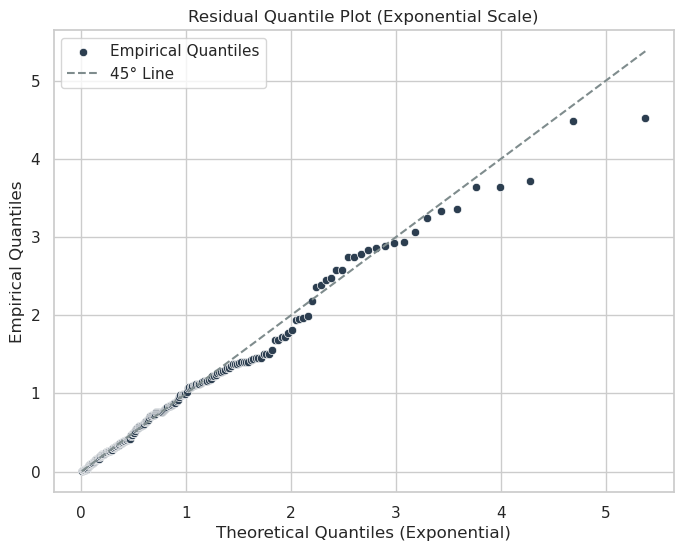

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/case_study/ald/case_study_cgpd_regression_results.svg


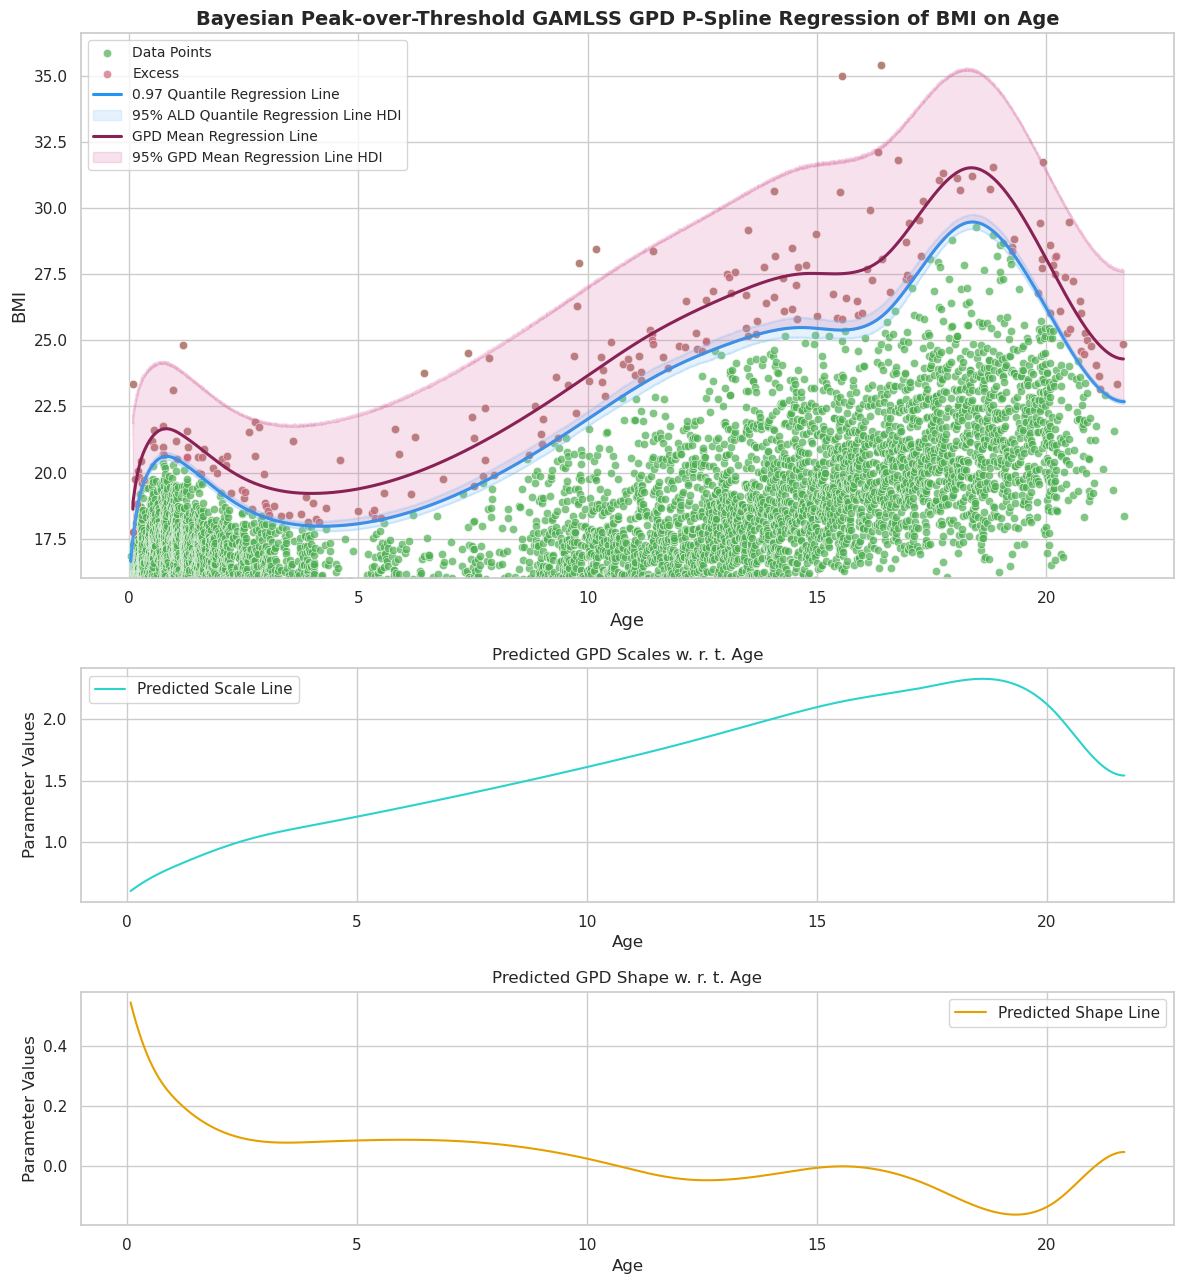

In [14]:
epochs_QR = 13000
epochs_GPD = 10000

DesignMatrixQR, X, Y, K_QR, knots_QR = vigamlss_dbbmi_prepare_qr_data()
model_QR, tau = vigamlss_dbbmi_qr_define_model(DesignMatrixQR, Y, K_QR)
results_QR = vigamlss_dbbmi_qr_opt_run(model_QR, epochs_QR)
(
    Y_excess,
    X_excess,
    excess_mask,
    pred_X_sorted,
    mask_X,
    pred_thresholds,
    pred_threshold_hdi_lower,
    pred_threshold_hdi_upper,
) = vigamlss_dbbmi_qr_results(results_QR, model_QR, knots_QR, X, Y, tau)

DesignMatrixCGPD, K_excess, knots_CGPD = vigamlss_dbbmi_prepare_gpd_data(X_excess)
model_CGPD = vigamlss_dbbmi_cgpd_define_model(DesignMatrixCGPD, Y_excess, K_excess)
results_CGPD = vigamlss_dbbmi_cgpd_opt_run(model_CGPD, epochs_GPD)
vigamlss_dbbmi_cgpd_results(
    results_CGPD,
    X,
    Y,
    X_excess,
    Y_excess,
    knots_CGPD,
    tau,
    excess_mask,
    pred_X_sorted,
    mask_X,
    pred_thresholds,
    pred_threshold_hdi_lower,
    pred_threshold_hdi_upper,
)